## 1. Setup & Database Connection

In [3]:
# Import required libraries
import os
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from IPython.display import display, Markdown

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Configure visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load environment variables
load_dotenv()

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [4]:
# Database configuration
DB_CONFIG = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'user': os.getenv('DB_USER', 'postgres'),
    'password': os.getenv('DB_PASSWORD'),
    'port': int(os.getenv('DB_PORT', '5432')),
    'database': os.getenv('TARGET_DB_NAME', 'airbnb_dimensional')
}

# Target property ID
TARGET_PROPERTY_ID = '1426378005713860735'

# Validate configuration
if not DB_CONFIG['password']:
    raise ValueError("DB_PASSWORD not set in environment variables")

print("✓ Configuration loaded:")
print(f"  Database: {DB_CONFIG['database']}")
print(f"  Host: {DB_CONFIG['host']}:{DB_CONFIG['port']}")
print(f"  Target Property: {TARGET_PROPERTY_ID}")

✓ Configuration loaded:
  Database: airbnb_dimensional
  Host: localhost:5432
  Target Property: 1426378005713860735


In [5]:
# Connect to dimensional database
try:
    conn = psycopg2.connect(**DB_CONFIG)
    cursor = conn.cursor()
    
    # Verify connection
    cursor.execute("SELECT version();")
    version = cursor.fetchone()[0]
    
    print("✓ Connected to dimensional database")
    print(f"  PostgreSQL: {version.split(',')[0]}")
    
except psycopg2.Error as e:
    print(f"✗ Connection failed: {e}")
    raise

✓ Connected to dimensional database
  PostgreSQL: PostgreSQL 18.0 on x86_64-windows


## 2. Property Overview

Retrieve comprehensive details for the target property including:
- Physical characteristics (bedrooms, bathrooms, capacity)
- Location and geographic tier
- Host information and reputation
- Ratings and quality metrics
- Current pricing and performance indicators

In [6]:
def get_property_overview(property_id):
    """
    Retrieve comprehensive property details from the dimensional database.
    
    This function queries the view_listing_summary view which denormalizes
    all dimension tables for easy access to complete property information.
    
    Parameters
    ----------
    property_id : str
        Unique identifier for the Airbnb property
    
    Returns
    -------
    pandas.DataFrame
        Single row with all property details, or empty DataFrame if not found
    
    Notes
    -----
    The query retrieves data from view_listing_summary which joins:
    - fact_listing_metrics (central fact table)
    - dim_property (physical characteristics)
    - dim_location (geographic data)
    - dim_host (host reputation)
    - dim_category_ratings (quality metrics)
    - fact_listing_amenities_summary (amenity aggregates)
    """
    query = """
        SELECT 
            listing_key,
            property_id,
            listing_name,
            category,
            guests_capacity,
            bedrooms,
            beds,
            baths,
            property_size_tier,
            
            -- Location
            city,
            province,
            latitude,
            longitude,
            location_tier,
            location_cluster_id,
            distance_to_downtown_km,
            
            -- Host
            host_id,
            host_name,
            host_rating,
            is_superhost,
            host_tier,
            experience_level,
            
            -- Ratings
            listing_rating,
            number_of_reviews,
            cleanliness_rating,
            accuracy_rating,
            location_rating,
            value_rating,
            overall_quality_score,
            quality_tier,
            
            -- Pricing & Metrics
            price_per_night,
            price_per_guest,
            price_per_bedroom,
            competitiveness_score,
            value_score,
            popularity_index,
            
            -- Amenities
            total_amenities_count,
            amenity_tier,
            amenity_score,
            
            -- Status
            is_available,
            is_guest_favorite,
            pets_allowed
            
        FROM view_listing_summary
        WHERE property_id = %s;
    """
    
    df = pd.read_sql_query(query, conn, params=(property_id,))
    return df


# Retrieve property details
df_property = get_property_overview(TARGET_PROPERTY_ID)

if df_property.empty:
    print(f"⚠ Property ID {TARGET_PROPERTY_ID} not found in database")
    print("  Possible reasons:")
    print("  - Property ID is incorrect")
    print("  - ETL has not been run yet")
    print("  - Property was not included in the source data")
else:
    print(f"✓ Property found: {df_property['listing_name'].iloc[0]}")
    print(f"  Listing Key: {df_property['listing_key'].iloc[0]}")
    print("\n" + "="*80)
    display(df_property.T)

✓ Property found: Entire condo in Calgary, Canada
  Listing Key: 1



C:\Users\Ale\AppData\Local\Temp\ipykernel_6408\4150457443.py:89: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=(property_id,))


,0
listing_key,1
property_id,1426378005713860735
listing_name,"Entire condo in Calgary, Canada"
category,Stays
guests_capacity,4
bedrooms,1
beds,2
baths,1
property_size_tier,Small
city,Calgary


In [7]:
# Display key property metrics in a formatted summary
if not df_property.empty:
    prop = df_property.iloc[0]
    
    summary = f"""
    # 📍 Property Summary
    
    ## Basic Information
    - **Name**: {prop['listing_name']}
    - **Category**: {prop['category']}
    - **Location**: {prop['city']}, {prop['province']} ({prop['location_tier']})
    - **Distance to Downtown**: {prop['distance_to_downtown_km']:.2f} km
    
    ## Property Characteristics
    - **Capacity**: {prop['guests_capacity']} guests
    - **Bedrooms**: {prop['bedrooms']} | **Beds**: {prop['beds']} | **Bathrooms**: {prop['baths']}
    - **Size Tier**: {prop['property_size_tier']}
    - **Amenities**: {prop['total_amenities_count']} total ({prop['amenity_tier']} tier, score: {prop['amenity_score']})
    
    ## Host Information
    - **Host**: {prop['host_name']} (ID: {prop['host_id']})
    - **Host Rating**: {prop['host_rating']:.2f}/5.0
    - **Superhost**: {'Yes ⭐' if prop['is_superhost'] else 'No'}
    - **Host Tier**: {prop['host_tier']} ({prop['experience_level']})
    
    ## Ratings & Reviews
    - **Overall Rating**: {prop['listing_rating']:.2f}/5.0 ({prop['quality_tier']})
    - **Number of Reviews**: {prop['number_of_reviews']}
    - **Cleanliness**: {prop['cleanliness_rating']:.2f} | **Accuracy**: {prop['accuracy_rating']:.2f}
    - **Location**: {prop['location_rating']:.2f} | **Value**: {prop['value_rating']:.2f}
    - **Overall Quality Score**: {prop['overall_quality_score']:.2f}/5.0
    
    ## Pricing & Performance
    - **Price per Night**: ${prop['price_per_night']:.2f} CAD
    - **Price per Guest**: ${prop['price_per_guest']:.2f}
    - **Price per Bedroom**: ${prop['price_per_bedroom']:.2f}
    - **Competitiveness Score**: {prop['competitiveness_score']:.2f}/100
    - **Value Score**: {prop['value_score']:.2f}/100
    - **Popularity Index**: {prop['popularity_index']:.2f}
    
    ## Status
    - **Available**: {'Yes ✓' if prop['is_available'] else 'No'}
    - **Guest Favorite**: {'Yes ❤️' if prop['is_guest_favorite'] else 'No'}
    - **Pets Allowed**: {'Yes 🐾' if prop['pets_allowed'] else 'No'}
    """
    
    display(Markdown(summary))


    # 📍 Property Summary

    ## Basic Information
    - **Name**: Entire condo in Calgary, Canada
    - **Category**: Stays
    - **Location**: Calgary, Alberta (Downtown Adjacent)
    - **Distance to Downtown**: 1.45 km

    ## Property Characteristics
    - **Capacity**: 4 guests
    - **Bedrooms**: 1 | **Beds**: 2 | **Bathrooms**: 1
    - **Size Tier**: Small
    - **Amenities**: 50 total (Standard tier, score: 18)

    ## Host Information
    - **Host**: Marc & Elizabeth (ID: 276673304)
    - **Host Rating**: 5.00/5.0
    - **Superhost**: No
    - **Host Tier**: Premium (New)

    ## Ratings & Reviews
    - **Overall Rating**: 5.00/5.0 (Exceptional)
    - **Number of Reviews**: 3
    - **Cleanliness**: 5.00 | **Accuracy**: 5.00
    - **Location**: 5.00 | **Value**: 4.70
    - **Overall Quality Score**: 4.94/5.0

    ## Pricing & Performance
    - **Price per Night**: $181.50 CAD
    - **Price per Guest**: $45.38
    - **Price per Bedroom**: $181.50
    - **Competitiveness Score**: 30.75/100
    - **Value Score**: 100.00/100
    - **Popularity Index**: 1.50

    ## Status
    - **Available**: Yes ✓
    - **Guest Favorite**: No
    - **Pets Allowed**: No
    

## 3. Top 25 Competitors Analysis

The dimensional database pre-computes the top 25 most similar competitors for each listing using a multi-factor similarity algorithm:

**Similarity Components:**
- **Location** (35%): Geographic distance and cluster membership
- **Property** (25%): Bedroom/bed/bath/capacity match
- **Quality** (20%): Rating and quality tier alignment
- **Amenity** (10%): Shared amenities (Jaccard coefficient)
- **Price** (10%): Price range overlap

Higher scores indicate stronger competition.

In [8]:
def get_top_competitors(property_id):
    """
    Retrieve top 25 competitors for a given property.
    
    This function queries the materialized view_top_competitors which
    contains pre-computed similarity scores and competitor relationships
    from the bridge_listing_competitors table.
    
    Parameters
    ----------
    property_id : str
        Unique identifier for the source property
    
    Returns
    -------
    pandas.DataFrame
        Up to 25 rows with competitor details and similarity metrics
    
    Notes
    -----
    The view includes:
    - Similarity rank (1-25, where 1 is most similar)
    - Overall similarity score (0-100)
    - Component similarity scores (location, property, quality, amenity, price)
    - Price comparison
    - Geographic distance
    """
    query = """
        SELECT 
            vtc.similarity_rank,
            vtc.competitor_property_id,
            
            -- Competitor details from dim_property
            p.listing_name as competitor_name,
            p.bedrooms as competitor_bedrooms,
            p.beds as competitor_beds,
            p.baths as competitor_baths,
            p.guests_capacity as competitor_guests,
            
            -- Competitor location
            l.location_tier as competitor_location_tier,
            vtc.distance_km,
            
            -- Pricing
            vtc.source_price as my_price,
            vtc.competitor_price,
            (vtc.competitor_price - vtc.source_price) as price_difference,
            ROUND(((vtc.competitor_price - vtc.source_price) / vtc.source_price * 100), 2) as price_diff_pct,
            
            -- Ratings
            vtc.competitor_rating,
            f.number_of_reviews as competitor_reviews,
            
            -- Similarity scores
            vtc.overall_similarity_score,
            vtc.location_similarity,
            vtc.property_similarity,
            vtc.quality_similarity,
            vtc.amenity_similarity,
            vtc.price_similarity,
            vtc.weight
            
        FROM view_top_competitors vtc
        -- Join to get listing_key for source property
        JOIN fact_listing_metrics f_source ON vtc.listing_key = f_source.listing_key
        -- Join to get competitor details
        JOIN fact_listing_metrics f ON vtc.competitor_listing_key = f.listing_key
        JOIN dim_property p ON f.property_key = p.property_key
        JOIN dim_location l ON f.location_key = l.location_key
        
        WHERE f_source.property_id = %s
        ORDER BY vtc.similarity_rank;
    """
    
    df = pd.read_sql_query(query, conn, params=(property_id,))
    return df


# Retrieve competitors
if not df_property.empty:
    df_competitors = get_top_competitors(TARGET_PROPERTY_ID)
    
    if df_competitors.empty:
        print(f"⚠ No competitors found for property {TARGET_PROPERTY_ID}")
        print("  This may indicate that competitor analysis has not been run yet.")
    else:
        print(f"✓ Found {len(df_competitors)} competitors")
        print("\nTop 25 Competitors:")
        print("="*100)
        
        # Display key columns
        display_cols = [
            'similarity_rank', 'competitor_property_id', 'competitor_name',
            'overall_similarity_score', 'competitor_price', 'price_diff_pct',
            'distance_km', 'competitor_bedrooms', 'competitor_rating'
        ]
        display(df_competitors[display_cols])

✓ Found 25 competitors

Top 25 Competitors:


C:\Users\Ale\AppData\Local\Temp\ipykernel_6408\3479235494.py:75: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=(property_id,))


,similarity_rank,competitor_property_id,competitor_name,overall_similarity_score,competitor_price,price_diff_pct,distance_km,competitor_bedrooms,competitor_rating
0,1,917958382556358309,"Entire rental unit in Calgary, Canada",97.00,169.98,-6.35,0.44,1,4.88
1,2,52441913,"Entire rental unit in Calgary, Canada",86.09,179.00,-1.38,0.77,1,5.00
2,3,52442502,"Entire rental unit in Calgary, Canada",85.75,179.00,-1.38,0.80,1,5.00
3,4,1326868547821997402,"Entire rental unit in Calgary, Canada",84.85,140.94,-22.35,0.48,2,4.83
4,5,551855963871300920,"Entire condo in Calgary, Canada",83.02,183.32,1.00,1.07,1,4.98
5,6,1364877517827164127,"Entire condo in Calgary, Canada",82.73,160.00,-11.85,1.07,1,5.00
6,7,897769858007491976,"Entire rental unit in Calgary, Canada",82.71,179.50,-1.10,1.11,1,4.93
7,8,1314598866425258757,"Entire rental unit in Calgary, Canada",82.43,170.11,-6.28,1.01,1,4.94
8,9,1505895536444280349,"Entire rental unit in Calgary, Canada",81.99,174.67,-3.76,1.15,1,4.88
9,10,5278986,"Entire condo in Calgary, Canada",81.74,123.08,-32.19,0.68,1,4.68


In [9]:
# Display similarity component breakdown
if not df_property.empty and not df_competitors.empty:
    print("\nSimilarity Score Components (Average across top 25):")
    print("="*60)
    
    similarity_cols = [
        'overall_similarity_score',
        'location_similarity',
        'property_similarity',
        'quality_similarity',
        'amenity_similarity',
        'price_similarity'
    ]
    
    avg_similarity = df_competitors[similarity_cols].mean()
    
    # Create a formatted dataframe
    similarity_df = pd.DataFrame({
        'Component': [
            'Overall Similarity',
            'Location (35% weight)',
            'Property (25% weight)',
            'Quality (20% weight)',
            'Amenity (10% weight)',
            'Price (10% weight)'
        ],
        'Average Score': avg_similarity.values,
        'Max Score': df_competitors[similarity_cols].max().values,
        'Min Score': df_competitors[similarity_cols].min().values
    })
    
    display(similarity_df)


Similarity Score Components (Average across top 25):


,Component,Average Score,Max Score,Min Score
0,Overall Similarity,82.17,97.00,79.23
1,Location (35% weight),64.69,100.00,52.15
2,Property (25% weight),92.60,100.00,50.00
3,Quality (20% weight),96.20,100.00,50.00
4,Amenity (10% weight),92.80,100.00,78.00
5,Price (10% weight),78.60,98.80,23.98


## 4. Pricing Analysis & Recommendations

The dimensional database calculates optimal pricing based on competitor analysis:

**Methodology:**
1. Calculate weighted average competitor price (using similarity scores as weights)
2. Apply quality adjustment factor based on relative rating
3. Determine price bounds (25th and 75th percentiles)
4. Generate optimal price recommendation

**Pricing Status:**
- **OPTIMAL**: Price within recommended range
- **OVERPRICED**: Price above upper bound
- **UNDERPRICED**: Price below lower bound

In [10]:
def get_pricing_analysis(property_id):
    """
    Retrieve detailed pricing analysis and recommendations.
    
    This function queries both view_price_recommendations and
    fact_competitor_pricing_analysis to get comprehensive pricing insights.
    
    Parameters
    ----------
    property_id : str
        Unique identifier for the property
    
    Returns
    -------
    pandas.DataFrame
        Single row with pricing analysis metrics
    
    Notes
    -----
    The analysis includes:
    - Current price vs. competitor statistics
    - Recommended optimal price
    - Price bounds (lower and upper)
    - Premium/discount percentage
    - Pricing status classification
    """
    query = """
        SELECT 
            vpr.property_id,
            vpr.listing_name,
            vpr.current_price,
            vpr.listing_rating,
            vpr.number_of_reviews,
            
            -- Competitor pricing statistics
            vpr.competitor_count,
            vpr.avg_competitor_price,
            vpr.median_competitor_price,
            vpr.weighted_avg_price,
            vpr.percentile_25_price,
            vpr.percentile_75_price,
            
            -- Recommendations
            vpr.recommended_optimal_price,
            vpr.recommended_price_lower,
            vpr.recommended_price_upper,
            vpr.price_premium_discount,
            vpr.price_difference,
            vpr.pricing_status,
            
            -- Context
            vpr.bedrooms,
            vpr.location_tier,
            vpr.analysis_date
            
        FROM view_price_recommendations vpr
        WHERE vpr.property_id = %s;
    """
    
    df = pd.read_sql_query(query, conn, params=(property_id,))
    return df


# Retrieve pricing analysis
if not df_property.empty:
    df_pricing = get_pricing_analysis(TARGET_PROPERTY_ID)
    
    if df_pricing.empty or pd.isna(df_pricing['recommended_optimal_price'].iloc[0]):
        print(f"⚠ Pricing analysis not available for property {TARGET_PROPERTY_ID}")
        print("  This may indicate that competitor pricing analysis has not been computed yet.")
    else:
        print("✓ Pricing analysis retrieved")
        print("\nPricing Analysis:")
        print("="*80)
        display(df_pricing.T)

✓ Pricing analysis retrieved

Pricing Analysis:


C:\Users\Ale\AppData\Local\Temp\ipykernel_6408\1697580655.py:60: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=(property_id,))


,0
property_id,1426378005713860735
listing_name,"Entire condo in Calgary, Canada"
current_price,181.50
listing_rating,5.00
number_of_reviews,3
competitor_count,25
avg_competitor_price,169.80
median_competitor_price,169.75
weighted_avg_price,169.60
percentile_25_price,160.00


In [11]:
# Display formatted pricing summary
if not df_property.empty and not df_pricing.empty:
    if not pd.isna(df_pricing['recommended_optimal_price'].iloc[0]):
        pricing = df_pricing.iloc[0]
        
        # Determine status emoji
        status_emoji = {
            'OPTIMAL': '✓',
            'OVERPRICED': '⚠',
            'UNDERPRICED': '💡'
        }
        
        summary = f"""
        # 💰 Pricing Analysis Summary
        
        ## Current Pricing
        - **Current Price**: ${pricing['current_price']:.2f} CAD/night
        - **Status**: {status_emoji.get(pricing['pricing_status'], '?')} {pricing['pricing_status']}
        - **Premium/Discount**: {pricing['price_premium_discount']:.2f}%
        
        ## Competitor Market Analysis
        - **Competitors Analyzed**: {int(pricing['competitor_count'])}
        - **Average Competitor Price**: ${pricing['avg_competitor_price']:.2f}
        - **Median Competitor Price**: ${pricing['median_competitor_price']:.2f}
        - **Weighted Average** (by similarity): ${pricing['weighted_avg_price']:.2f}
        - **25th Percentile**: ${pricing['percentile_25_price']:.2f}
        - **75th Percentile**: ${pricing['percentile_75_price']:.2f}
        
        ## Price Recommendations
        - **Optimal Price**: ${pricing['recommended_optimal_price']:.2f} CAD/night
        - **Recommended Range**: ${pricing['recommended_price_lower']:.2f} - ${pricing['recommended_price_upper']:.2f}
        - **Potential Adjustment**: {'+' if pricing['price_difference'] < 0 else '-'}${abs(pricing['price_difference']):.2f}
        
        ## Strategic Insights
        """
        
        if pricing['pricing_status'] == 'OPTIMAL':
            summary += "\n- ✓ Your pricing is well-aligned with comparable properties\n"
            summary += "- Consider maintaining current price unless market conditions change\n"
        elif pricing['pricing_status'] == 'OVERPRICED':
            summary += f"\n- ⚠ Your price is {pricing['price_premium_discount']:.1f}% above market average\n"
            summary += f"- Consider reducing price to ${pricing['recommended_optimal_price']:.2f} to improve competitiveness\n"
            summary += "- May be limiting booking potential\n"
        else:  # UNDERPRICED
            summary += f"\n- 💡 Your price is {abs(pricing['price_premium_discount']):.1f}% below market average\n"
            summary += f"- Consider increasing price to ${pricing['recommended_optimal_price']:.2f}\n"
            summary += f"- Potential revenue gain: ${abs(pricing['price_difference']) * 30:.2f}/month (assuming 30 nights)\n"
        
        display(Markdown(summary))


        # 💰 Pricing Analysis Summary

        ## Current Pricing
        - **Current Price**: $181.50 CAD/night
        - **Status**: ✓ OPTIMAL
        - **Premium/Discount**: 7.02%

        ## Competitor Market Analysis
        - **Competitors Analyzed**: 25
        - **Average Competitor Price**: $169.80
        - **Median Competitor Price**: $169.75
        - **Weighted Average** (by similarity): $169.60
        - **25th Percentile**: $160.00
        - **75th Percentile**: $179.00

        ## Price Recommendations
        - **Optimal Price**: $188.44 CAD/night
        - **Recommended Range**: $152.00 - $187.95
        - **Potential Adjustment**: +$6.94

        ## Strategic Insights
        
- ✓ Your pricing is well-aligned with comparable properties
- Consider maintaining current price unless market conditions change


## 5. Visualizations

Visual analysis of competitor landscape and pricing positioning.

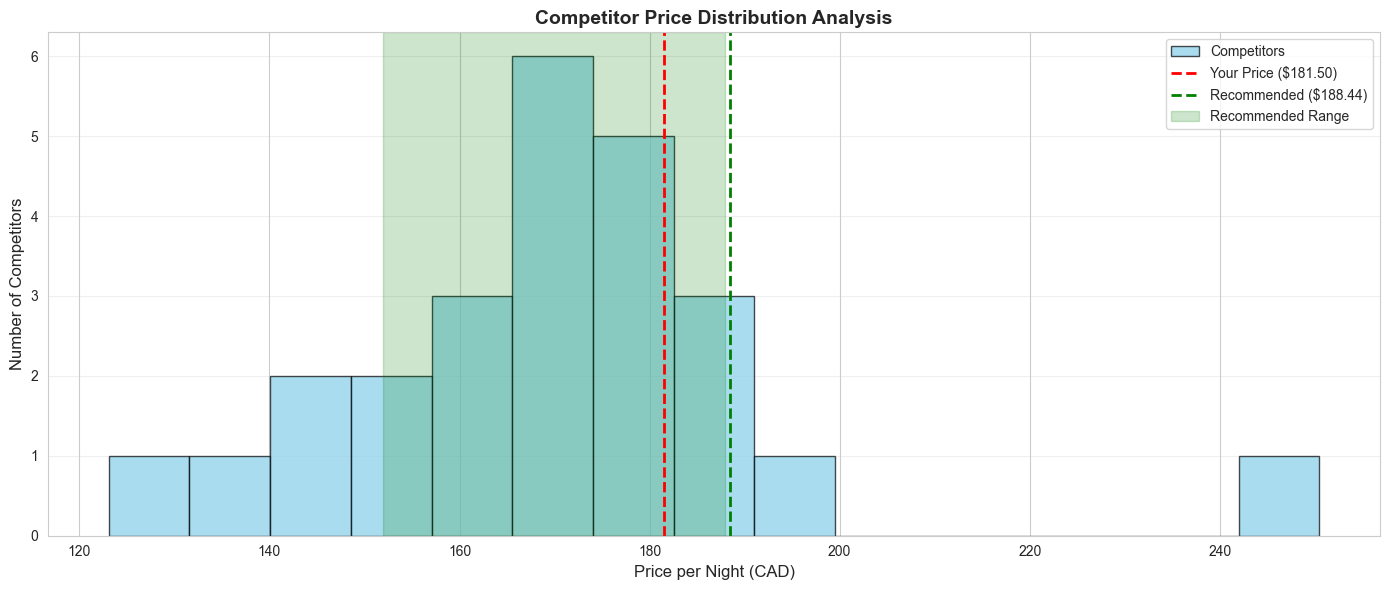


Price Statistics:
  Your Price: $181.50
  Competitor Average: $169.80
  Competitor Median: $169.75
  Competitor Range: $123.08 - $250.49


In [12]:
# Visualization 1: Competitor Price Distribution
if not df_property.empty and not df_competitors.empty:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Histogram of competitor prices
    ax.hist(df_competitors['competitor_price'], bins=15, alpha=0.7, 
            color='skyblue', edgecolor='black', label='Competitors')
    
    # Mark current price
    current_price = df_property['price_per_night'].iloc[0]
    ax.axvline(current_price, color='red', linestyle='--', linewidth=2, 
               label=f'Your Price (${current_price:.2f})')
    
    # Mark recommended price if available
    if not df_pricing.empty and not pd.isna(df_pricing['recommended_optimal_price'].iloc[0]):
        optimal_price = df_pricing['recommended_optimal_price'].iloc[0]
        ax.axvline(optimal_price, color='green', linestyle='--', linewidth=2,
                   label=f'Recommended (${optimal_price:.2f})')
        
        # Mark price bounds
        lower = df_pricing['recommended_price_lower'].iloc[0]
        upper = df_pricing['recommended_price_upper'].iloc[0]
        ax.axvspan(lower, upper, alpha=0.2, color='green', label='Recommended Range')
    
    ax.set_xlabel('Price per Night (CAD)', fontsize=12)
    ax.set_ylabel('Number of Competitors', fontsize=12)
    ax.set_title('Competitor Price Distribution Analysis', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"\nPrice Statistics:")
    print(f"  Your Price: ${current_price:.2f}")
    print(f"  Competitor Average: ${df_competitors['competitor_price'].mean():.2f}")
    print(f"  Competitor Median: ${df_competitors['competitor_price'].median():.2f}")
    print(f"  Competitor Range: ${df_competitors['competitor_price'].min():.2f} - ${df_competitors['competitor_price'].max():.2f}")

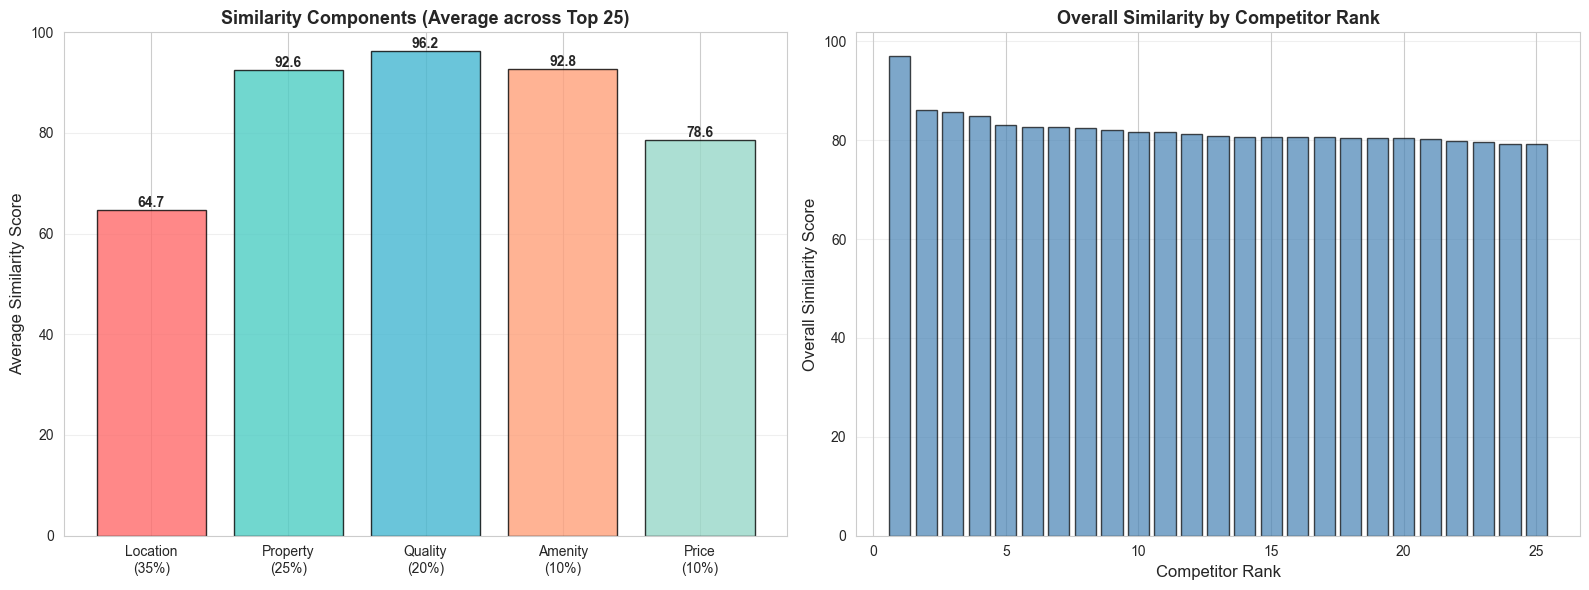

In [13]:
# Visualization 2: Similarity Score Components
if not df_property.empty and not df_competitors.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Average similarity components
    components = ['Location\n(35%)', 'Property\n(25%)', 'Quality\n(20%)', 
                  'Amenity\n(10%)', 'Price\n(10%)']
    scores = [
        df_competitors['location_similarity'].mean(),
        df_competitors['property_similarity'].mean(),
        df_competitors['quality_similarity'].mean(),
        df_competitors['amenity_similarity'].mean(),
        df_competitors['price_similarity'].mean()
    ]
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
    bars = ax1.bar(components, scores, color=colors, alpha=0.8, edgecolor='black')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontweight='bold')
    
    ax1.set_ylabel('Average Similarity Score', fontsize=12)
    ax1.set_title('Similarity Components (Average across Top 25)', fontsize=13, fontweight='bold')
    ax1.set_ylim(0, 100)
    ax1.grid(axis='y', alpha=0.3)
    
    # Overall similarity distribution
    ax2.bar(df_competitors['similarity_rank'], 
            df_competitors['overall_similarity_score'],
            color='steelblue', alpha=0.7, edgecolor='black')
    
    ax2.set_xlabel('Competitor Rank', fontsize=12)
    ax2.set_ylabel('Overall Similarity Score', fontsize=12)
    ax2.set_title('Overall Similarity by Competitor Rank', fontsize=13, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

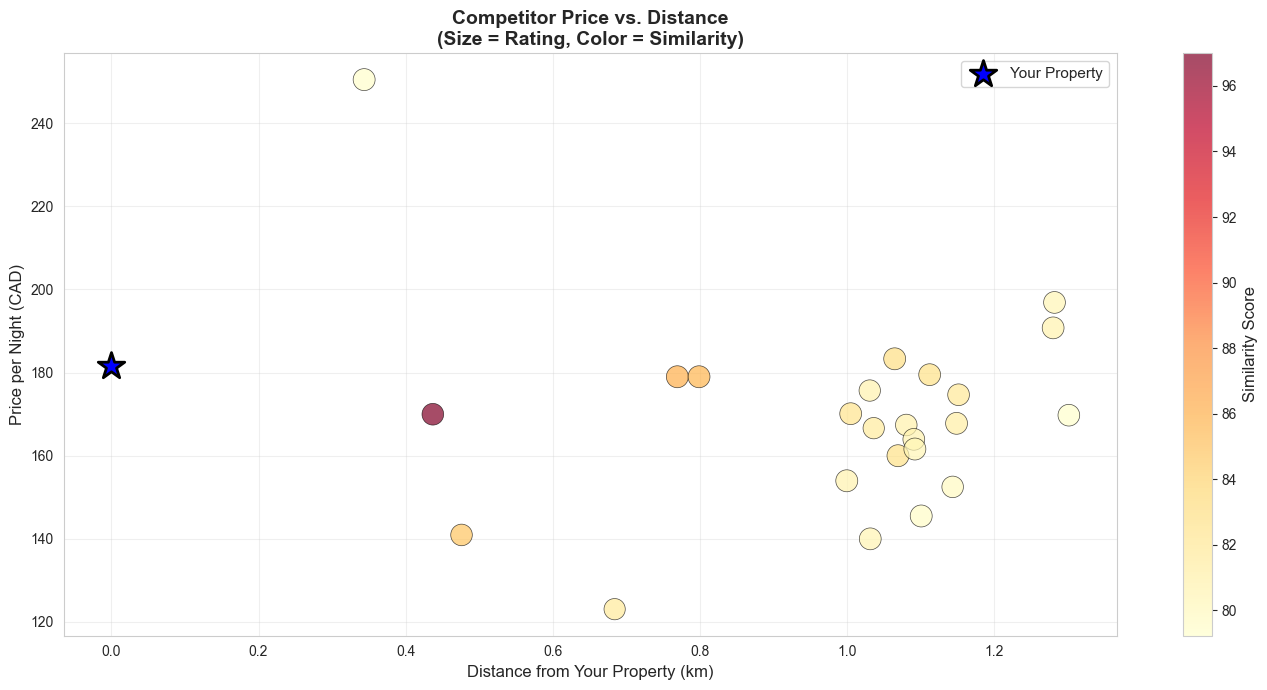

In [14]:
# Visualization 3: Price vs. Distance Scatter Plot
if not df_property.empty and not df_competitors.empty:
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Scatter plot colored by similarity score
    scatter = ax.scatter(
        df_competitors['distance_km'],
        df_competitors['competitor_price'],
        c=df_competitors['overall_similarity_score'],
        s=df_competitors['competitor_rating'] * 50,  # Size by rating
        cmap='YlOrRd',
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5
    )
    
    # Add your property
    your_distance = 0  # Assuming comparing to same reference point
    ax.scatter(your_distance, current_price, 
              color='blue', s=400, marker='*', 
              edgecolors='black', linewidth=2,
              label='Your Property', zorder=5)
    
    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Similarity Score', fontsize=12)
    
    ax.set_xlabel('Distance from Your Property (km)', fontsize=12)
    ax.set_ylabel('Price per Night (CAD)', fontsize=12)
    ax.set_title('Competitor Price vs. Distance\n(Size = Rating, Color = Similarity)', 
                fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

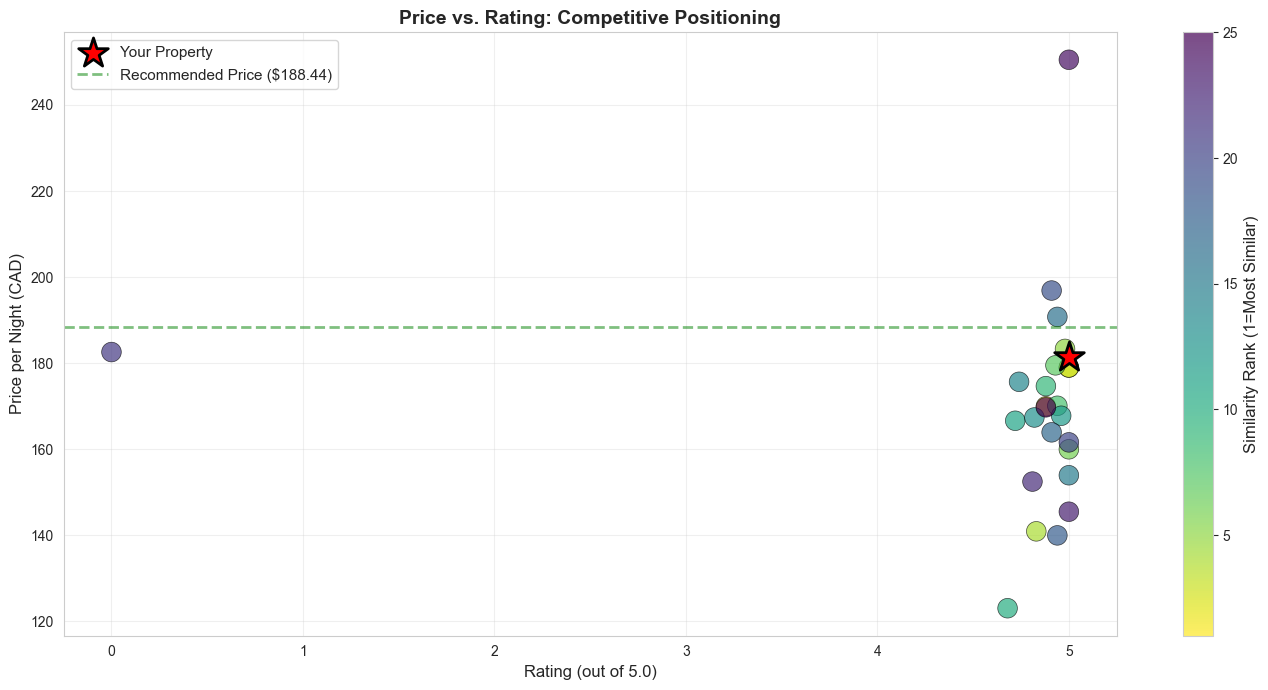

In [15]:
# Visualization 4: Price vs. Rating Comparison
if not df_property.empty and not df_competitors.empty:
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Scatter plot
    scatter = ax.scatter(
        df_competitors['competitor_rating'],
        df_competitors['competitor_price'],
        c=df_competitors['similarity_rank'],
        s=200,
        cmap='viridis_r',
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5
    )
    
    # Add your property
    your_rating = df_property['listing_rating'].iloc[0]
    ax.scatter(your_rating, current_price,
              color='red', s=500, marker='*',
              edgecolors='black', linewidth=2,
              label='Your Property', zorder=5)
    
    # Add optimal price line if available
    if not df_pricing.empty and not pd.isna(df_pricing['recommended_optimal_price'].iloc[0]):
        optimal_price = df_pricing['recommended_optimal_price'].iloc[0]
        ax.axhline(optimal_price, color='green', linestyle='--', 
                   linewidth=2, alpha=0.5, label=f'Recommended Price (${optimal_price:.2f})')
    
    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Similarity Rank (1=Most Similar)', fontsize=12)
    
    ax.set_xlabel('Rating (out of 5.0)', fontsize=12)
    ax.set_ylabel('Price per Night (CAD)', fontsize=12)
    ax.set_title('Price vs. Rating: Competitive Positioning', 
                fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 6. Summary & Strategic Recommendations

Comprehensive analysis summary with actionable insights.

In [ ]:
# Generate comprehensive summary
if not df_property.empty:
    prop = df_property.iloc[0]
    
    report = f"""
    # 📊 Executive Summary: Competitive Analysis Report
    
    **Property**: {prop['listing_name']} (ID: {TARGET_PROPERTY_ID})
    
    **Analysis Date**: {pd.Timestamp.now().strftime('%Y-%m-%d')}
    
    ---
    
    ## Key Findings
    
    ### 1. Property Performance
    - Current price: ${prop['price_per_night']:.2f} CAD/night
    - Overall rating: {prop['listing_rating']:.2f}/5.0 ({prop['quality_tier']})
    - Reviews: {prop['number_of_reviews']}
    - Competitiveness score: {prop['competitiveness_score']:.2f}/100
    - Value score: {prop['value_score']:.2f}/100
    
    """
    
    if not df_competitors.empty:
        report += f"""
    ### 2. Competitive Landscape
    - **Competitors analyzed**: {len(df_competitors)}
    - **Average competitor price**: ${df_competitors['competitor_price'].mean():.2f}
    - **Price range**: ${df_competitors['competitor_price'].min():.2f} - ${df_competitors['competitor_price'].max():.2f}
    - **Average similarity**: {df_competitors['overall_similarity_score'].mean():.1f}/100
    - **Average distance**: {df_competitors['distance_km'].mean():.2f} km
    
    #### Strongest Competition Factors:
    - Location similarity: {df_competitors['location_similarity'].mean():.1f}/100
    - Property similarity: {df_competitors['property_similarity'].mean():.1f}/100
    - Quality similarity: {df_competitors['quality_similarity'].mean():.1f}/100
        """
    
    if not df_pricing.empty and not pd.isna(df_pricing['recommended_optimal_price'].iloc[0]):
        pricing = df_pricing.iloc[0]
        report += f"""
    
    ### 3. Pricing Recommendations
    - **Status**: {pricing['pricing_status']}
    - **Recommended optimal price**: ${pricing['recommended_optimal_price']:.2f} CAD/night
    - **Recommended range**: ${pricing['recommended_price_lower']:.2f} - ${pricing['recommended_price_upper']:.2f}
    - **Current vs. optimal**: {'+' if pricing['price_difference'] < 0 else '-'}${abs(pricing['price_difference']):.2f}
    - **Market positioning**: {pricing['price_premium_discount']:.1f}% {'premium' if pricing['price_premium_discount'] > 0 else 'discount'}
        """
    
    report += f"""
    
    ## Strategic Recommendations
    
    ### Pricing Strategy
    """
    
    if not df_pricing.empty and not pd.isna(df_pricing['recommended_optimal_price'].iloc[0]):
        pricing = df_pricing.iloc[0]
        
        if pricing['pricing_status'] == 'OPTIMAL':
            report += """
    ✓ **Maintain Current Price**
      - Your pricing is well-aligned with the competitive market
      - Monitor competitor pricing weekly for any significant changes
      - Consider seasonal adjustments for Stampede (July) and Summer Peak seasons
            """
        elif pricing['pricing_status'] == 'OVERPRICED':
            potential_bookings = abs(pricing['price_difference']) / pricing['current_price'] * 100
            report += f"""
    ⚠ **Price Reduction Recommended**
      - Current price is {pricing['price_premium_discount']:.1f}% above market average
      - Recommended adjustment: -${abs(pricing['price_difference']):.2f} per night
      - Target price: ${pricing['recommended_optimal_price']:.2f}
      - Expected impact: May increase booking rate by ~{potential_bookings:.0f}%
      - Consider gradual reduction to test market response
            """
        else:  # UNDERPRICED
            monthly_gain = abs(pricing['price_difference']) * 30
            yearly_gain = monthly_gain * 12
            report += f"""
    💡 **Price Increase Opportunity**
      - Current price is {abs(pricing['price_premium_discount']):.1f}% below market average
      - Recommended adjustment: +${abs(pricing['price_difference']):.2f} per night
      - Target price: ${pricing['recommended_optimal_price']:.2f}
      - Potential additional revenue:
        * Monthly: ${monthly_gain:.2f} (assuming 30 bookings)
        * Yearly: ${yearly_gain:.2f} (assuming consistent bookings)
      - Your high quality score ({prop['overall_quality_score']:.2f}) supports premium pricing
            """
    
    report += f"""
    
    ### Competitive Advantages to Leverage
    """
    
    # Identify strengths
    strengths = []
    
    if prop['is_guest_favorite']:
        strengths.append("- ❤️ **Guest Favorite status** - Highlight in listing description")
    
    if prop['is_superhost']:
        strengths.append("- ⭐ **Superhost status** - Premium host reputation")
    
    if prop['overall_quality_score'] > 4.7:
        strengths.append(f"- 🏆 **Exceptional quality** ({prop['overall_quality_score']:.2f}/5.0) - Above market average")
    
    if prop['location_tier'] in ['Urban Core', 'Downtown Adjacent']:
        strengths.append(f"- 📍 **Prime location** ({prop['location_tier']}) - {prop['distance_to_downtown_km']:.1f} km to downtown")
    
    if prop['amenity_tier'] in ['Luxury', 'Premium']:
        strengths.append(f"- ✨ **{prop['amenity_tier']} amenities** ({prop['total_amenities_count']} total) - Above average offering")
    
    if strengths:
        report += "\n" + "\n".join(strengths)
    else:
        report += "\n- Consider enhancing amenities or service quality to differentiate"
    
    report += f"""
    
    ### Areas for Improvement
    """
    
    # Identify improvement areas
    improvements = []
    
    if prop['number_of_reviews'] < 10:
        improvements.append("- 📝 **Build review base** - Incentivize guests to leave reviews")
    
    if prop['cleanliness_rating'] < 4.8:
        improvements.append(f"- 🧹 **Enhance cleanliness** (current: {prop['cleanliness_rating']:.2f}) - Critical rating factor")
    
    if prop['value_rating'] < 4.5:
        improvements.append(f"- 💰 **Improve value perception** (current: {prop['value_rating']:.2f}) - Consider price adjustment or amenity additions")
    
    if prop['amenity_tier'] == 'Basic':
        improvements.append("- ➕ **Add amenities** - WiFi, kitchen essentials, or workspace can increase competitiveness")
    
    if improvements:
        report += "\n" + "\n".join(improvements)
    else:
        report += "\n- 🎯 Property is well-positioned - focus on maintaining quality and monitoring market"
    
    report += """
    
    
    """
    
    display(Markdown(report))


    # 📊 Executive Summary: Competitive Analysis Report

    **Property**: Entire condo in Calgary, Canada (ID: 1426378005713860735)

    **Analysis Date**: 2025-11-13

    ---

    ## Key Findings

    ### 1. Property Performance
    - Current price: $181.50 CAD/night
    - Overall rating: 5.00/5.0 (Exceptional)
    - Reviews: 3
    - Competitiveness score: 30.75/100
    - Value score: 100.00/100

    
    ### 2. Competitive Landscape
    - **Competitors analyzed**: 25
    - **Average competitor price**: $169.80
    - **Price range**: $123.08 - $250.49
    - **Average similarity**: 82.2/100
    - **Average distance**: 0.96 km

    #### Strongest Competition Factors:
    - Location similarity: 64.7/100
    - Property similarity: 92.6/100
    - Quality similarity: 96.2/100
        

    ### 3. Pricing Recommendations
    - **Status**: OPTIMAL
    - **Recommended optimal price**: $188.44 CAD/night
    - **Recommended range**: $152.00 - $187.95
    - **Current vs. optimal**: +$6.94
    - **Market positioning**: 7.0% premium
        

    ## Strategic Recommendations

    ### Pricing Strategy
    
    ✓ **Maintain Current Price**
      - Your pricing is well-aligned with the competitive market
      - Monitor competitor pricing weekly for any significant changes
      - Consider seasonal adjustments for Stampede (July) and Summer Peak seasons
            

    ### Competitive Advantages to Leverage
    
- 🏆 **Exceptional quality** (4.94/5.0) - Above market average
- 📍 **Prime location** (Downtown Adjacent) - 1.4 km to downtown

    ### Areas for Improvement
    
- 📝 **Build review base** - Incentivize guests to leave reviews

    ---

    ## Action Items

    1. **Immediate (This Week)**:
       - Review and adjust pricing based on recommendations
       - Update listing photos if older than 6 months
       - Verify all amenities are accurately listed

    2. **Short-term (This Month)**:
       - Monitor competitor pricing weekly
       - Implement any quality improvements identified
       - Test pricing adjustments with A/B testing if possible

    3. **Long-term (Next Quarter)**:
       - Re-run competitive analysis monthly
       - Track booking rate changes after pricing adjustments
       - Consider seasonal pricing strategy for Calgary events

    ---

    **Report Generated**: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

    **Data Source**: Airbnb Dimensional Database (airbnb_dimensional)
    

In [18]:
# Close database connection
if conn:
    conn.close()
    print("\n✓ Database connection closed")
    print("="*80)
    print("Analysis complete!")


✓ Database connection closed
Analysis complete!
